In [11]:
import copy
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import pandas as pd
import pickle
import statistics
import utm

# local .json file with local path info
geladas_root = os.path.dirname(os.getcwd())
local_paths_file = os.path.join(geladas_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])


import koger_general_functions as kgf
import mapping_functions as kmap
from drone_movement import create_gt_segment_dicts

plt.style.use('dark_background')

In [2]:
verbose = True
save = False

# change to specific observation name 
observation_name = "DJI_0205"
# Name of the track file that should be projected into landscape
tracks_name = "tracks-complete.npy"
# Name of folder where data extracted in "extract_drone_movement.ipynb" was saved
drone_movement_folder_name = "worked_examples_drone_movement"
# Project name assosiated with the saved pix4d files
pix4d_project_name = "gelada_worked_example_DJI_0205"

In [ ]:
# Parameters for projecting points from video into the 3D map
correct_threshold = 0.1 # Acceptable distance from target height above ground
max_guesses = 50 # Max tries to find a point along projection ray within correct_threshold  
initial_mu = 100 # Initial distance along projection ray to start searching
object_height = .5 # Target animal height above ground 

In [3]:
# Load files based on above names. Shouldn't need to be changed if previous
# notebooks were used
tracks_file = os.path.join(local_paths['base_gelada'], "processing", 
                           observation_name, tracks_name)
tracks = np.load(tracks_file, allow_pickle=True)

frame_folders_root = os.path.join(local_paths["videos_folder"], 
                                  "frames", observation_name) 
frame_files = sorted(glob.glob(os.path.join(frame_folders_root, "*.jpg")))

pix4d_folder = os.path.join(local_paths["pix4d_folder"], observation_name)
pix4d_info = kmap.get_pix4d_info(pix4d_folder, pix4d_project_name, pmatrix_sort='simple')

anchor_obs_inds = kmap.get_anchor_obs_indexes(pix4d_info['pmatrices'], 
                                              frame_files=frame_files)

drone_movement_folder = os.path.join(frame_folders_root, drone_movement_folder_name)
# List of affine movement matricies for each frame in each segment
segment_movement_files = glob.glob(
    os.path.join(drone_movement_folder,"drone_movement_segment_*.npy"))
segment_movements_list = [np.load(file) for file in sorted(segment_movement_files)]

0 frames processed


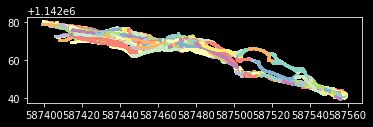

In [4]:
utm_tracks = kmap.video_tracks_to_utm(tracks, pix4d_info, anchor_obs_inds, 
                                 segment_movements_list, frame_files, 
                                 mu_est=initial_mu, max_guesses=max_guesses, 
                                 correct_threshold=correct_threshold, 
                                 object_height=object_height, verbose=verbose,
                                     correct_anchor_error=True)

for t in utm_tracks:
    plt.scatter(t[:,0], t[:,1], s=3)
plt.gca().set_aspect('equal')

if save:
    out_folder = os.path.join(local_paths['base_gelada'], 
                              "processing", observation_name)
    utm_tracks_file = os.path.join(out_folder, 'utm_tracks.npy')
    np.save(utm_tracks_file, utm_tracks)

### We can visualize these tracks on the landscape maps

In [5]:
# Load the rgb orthomosaic
geotif_image_file = os.path.join(pix4d_folder, "3_dsm_ortho", "2_mosaic",
                                 f"{pix4d_project_name}_transparent_mosaic_group1.tif") 
image_gtif = gdal.Open(geotif_image_file)

gtif_transform = image_gtif.GetGeoTransform()
x_origin = gtif_transform[0]
y_origin = gtif_transform[3]
pixel_width = gtif_transform[1]
pixel_height = gtif_transform[5]

pix4d_info = {'x_origin': x_origin,
              'y_origin': y_origin,
              'pixel_width': pixel_width,
              'pixel_height': pixel_height}

bands = []
for band_num in range(1, 4):
    srcband = image_gtif.GetRasterBand(band_num)
    a = srcband.ReadAsArray()
    bands.append(a)
orthomap = np.stack(bands, 2)

In [6]:
video_name = "DJI_0205"

base_folder = os.path.join(local_paths['base_gelada'], "processing", video_name)

# list of dicts that contains keys "pred_boxes", "scores", "pred_classes", 
# "image_name" for each frame
detections_file = os.path.join(base_folder, f"{video_name}_detections.npy")
detections_dicts = np.load(detections_file, allow_pickle=True)

In [7]:
def get_tracks_class(track, detections_dicts):
    """Assumes track has keys 'first_frame' """
    track_class = []
    for ind, det_num in enumerate(track['pos_index']):
        if np.isnan(det_num):
            continue
        obs_ind = track['first_frame'] + ind
        pred_class = detections_dicts[obs_ind]['pred_classes'][int(det_num)]
        track_class.append(pred_class)
    return np.array(track_class)

In [8]:
track_classes = []
for track in tracks:
    track_class = statistics.mode(get_tracks_class(track, detections_dicts))
    track_classes.append(track_class)

In [13]:
save_fig = True
plt.figure(figsize=(20, 20))
plt.imshow(orthomap)

s = .05

for utm_track, track_class in zip(utm_tracks, track_classes):
    raster_track = kmap.utm_to_raster_track(utm_track, pix4d_info, image_scale=1)
    if track_class == 0:
        c = 'navy'
        a = 1.0
    elif track_class == 1:
        c = 'white'
        a = .6
    plt.scatter(raster_track[:, 0], raster_track[:, 1], s=s, c=c, alpha=a)
    
for utm_track, track_class in zip(utm_tracks, track_classes):
    raster_track = kmap.utm_to_raster_track(utm_track, pix4d_info, image_scale=1)
    if track_class == 0:
        c = 'navy'
        a = 1.0
    elif track_class == 1:
        c = 'w'
        a = 0.0
    plt.scatter(raster_track[:, 0], raster_track[:, 1], s=s, c=c, alpha=a)
    
file = os.path.join(local_paths['figure_folder'], 
                    f"tracks_on_map_{video_name}_color_GCPs.png")
if save_fig:
    plt.savefig(file, format=None, metadata=None, dpi=300, bbox_inches='tight',
               transparent=True)

In [70]:
geotif_dsm_file =  os.path.join(pix4d_folder, "3_dsm_ortho", "1_dsm",
                                f"{pix4d_project_name}_dsm.tif")
dsm_gtif = gdal.Open(geotif_dsm_file)
dsm = dsm_gtif.GetRasterBand(1).ReadAsArray()

In [84]:
import cv2

In [85]:
geotif_dtm_file = os.path.join(pix4d_folder, "3_dsm_ortho", "extras", "dtm", 
                                   f"{pix4d_project_name}_dtm.tif")             
dtm_gtif = gdal.Open(geotif_dtm_file)
dtm = dtm_gtif.GetRasterBand(1).ReadAsArray()
dtm = np.where(dtm==-10000, np.min(np.ravel(dtm)[np.ravel(dtm)!=-10000]), dtm)
pix4d_info['elevation_r'] = cv2.resize(dtm, 
                                       (dsm_gtif.RasterXSize, 
                                        dsm_gtif.RasterYSize))

In [86]:
ag = dsm - pix4d_info['elevation_r']

In [91]:
plt.figure(figsize=(20,20))
plt.imshow(ag[1000:2500, 4000:8000])
plt.figure(figsize=(20,20))
plt.imshow(pix4d_info['elevation_r'])
plt.figure(figsize=(20,20))
plt.imshow(dsm)

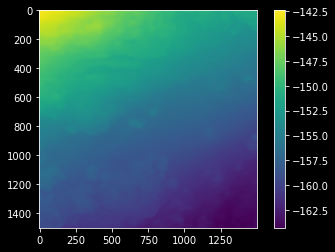

In [80]:
plt.imshow(dsm[1000:2500,1000:2500])
plt.colorbar()

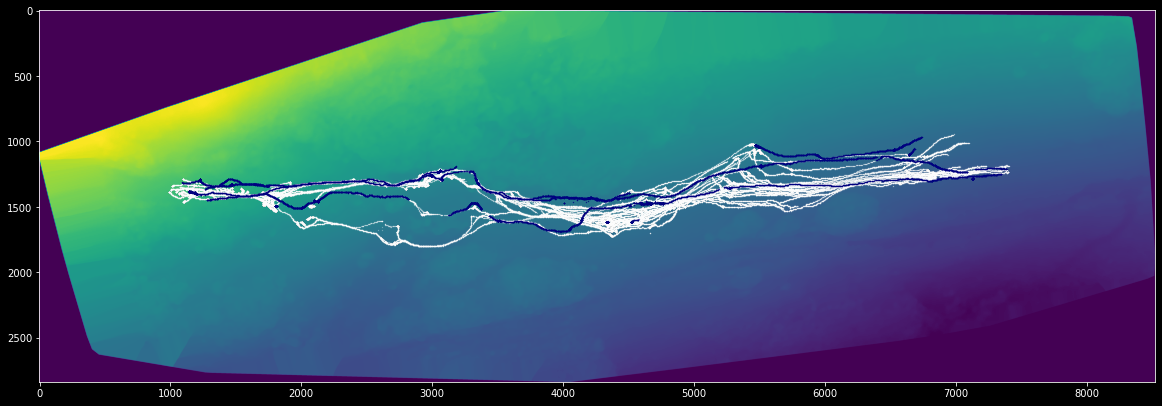

In [94]:
plt.figure(figsize=(20, 20))
plt.imshow(dsm)

s = .05

for utm_track, track_class in zip(utm_tracks, track_classes):
    raster_track = kmap.utm_to_raster_track(utm_track, pix4d_info, image_scale=1)
    if track_class == 0:
        c = 'navy'
        a = 1.0
    elif track_class == 1:
        c = 'white'
        a = .6
    plt.scatter(raster_track[:, 0], raster_track[:, 1], s=s, c=c, alpha=a)
    
for utm_track, track_class in zip(utm_tracks, track_classes):
    raster_track = kmap.utm_to_raster_track(utm_track, pix4d_info, image_scale=1)
    if track_class == 0:
        c = 'navy'
        a = 1.0
    elif track_class == 1:
        c = 'w'
        a = 0.0
    plt.scatter(raster_track[:, 0], raster_track[:, 1], s=s, c=c, alpha=a)
    
file = os.path.join(local_paths['plots_folder'], 
                    f"tracks_on_map_{video_name}_color.png")
# if save_fig:
#     plt.savefig(file, format=None, metadata=None, dpi=300, bbox_inches='tight',
#                transparent=True)

### Compare anchor frame locations in map and drone image

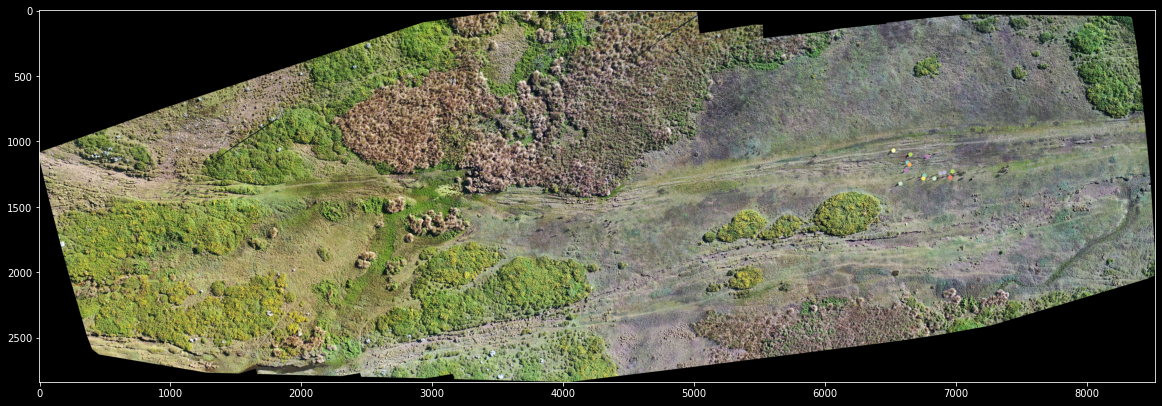

In [10]:
plt.figure(figsize=(20, 20))
plt.imshow(orthomap)

obs_ind = anchor_obs_inds[2]

for utm_track in utm_tracks:
    raster_track = kmap.utm_to_raster_track(utm_track[obs_ind:obs_ind+1], pix4d_info, image_scale=1)
    
    plt.scatter(raster_track[:, 0], raster_track[:, 1], s=10)

In [11]:
positions = []
track_classes = []
# Get positions for every individual in the ground truth frames
for track_ind, track in enumerate(tracks):
    rel_frame_number = obs_ind - track['first_frame']
    if rel_frame_number > 0:
        if rel_frame_number < track['track'].shape[0]:
            positions.append(track['track'][rel_frame_number])

In [12]:
frame = plt.imread(frame_files[obs_ind])

plt.figure(figsize=(20,20))
plt.imshow(frame)
for position in positions:
    plt.scatter(position[1], frame.shape[0] - position[0], s=15)